In [1]:
%matplotlib inline

## Boiler plate code common to many notebooks.  See the TestFilesCommonCode.ipynb for details
from __future__ import print_function
%run TestFilesCommonCode.ipynb

##
# IMPORTS
##
#import nibabel as nib
#import dipy.io
import scipy.io # for writing the .mat files
import numpy as np

SimpleITK Version: 0.9.1
Compiled: Sep 28 2015 10:07:41



In [2]:
##
# Input scans file names
##
dwi_1='/Shared/johnsonhj/HDNI/20150319_DWIProcessing/Results/PHD_024/0029/34504/Outputs/DWI_Corrected_Aligned_CS.nrrd'
dwi_2='/Shared/johnsonhj/HDNI/20150319_DWIProcessing/Results/PHD_024/0029/83611/Outputs/DWI_Corrected_Aligned_CS.nrrd'

# mask names
mask1_fn='/Shared/johnsonhj/HDNI/20150319_DWIProcessing/Results/PHD_024/0029/34504/Outputs/BrainMaskForDWI.nrrd'
mask2_fn='/Shared/johnsonhj/HDNI/20150319_DWIProcessing/Results/PHD_024/0029/83611/Outputs/BrainMaskForDWI.nrrd'
#
OUTPUT_DIR='/scratch/TESTS/dti_errors/MatlabFiles'
#

In [3]:
# 
# READ input DWI scan using pynrrd
#
import nrrd

class nrrdDWIHeader:
    """A helper class for manipulating header information
    from a nrrd DWI data set into a nibabel compliant
    format"""
    def __init__(self,pynrrdDataModel):
        self.modality=None                      #Matches NRRD File
        self.global_BValue=None                 #Matches NRRD File
        self.gradientUnormalizedVectors=[None]  #Matches NRRD File

        self.gradientIndex=-1
        self.gradientBValues=[None]             #Computed
        self.gradientVectors=[None]             #Computed
        self._ConvertNrrdToNibabelDWIDataModel(pynrrdDataModel)

    def Print(self):
        print("global_BValue {0}".format(self.global_BValue) )
        print("modality {0}".format(self.modality) )
        print("gradientBValues {0}".format(self.gradientBValues) )
        print("gradientDirections {0}".format(self.gradientUnormalizedVectors) )

    def _getGradientStorageIndex(self,pynrrdDataModel):
        """The 4D index that has separate gradients.
        all other directions are the spatial dimensions."""
        gradient_index=-1;
        centerings=pynrrdDataModel['centerings']
        numdwidims=len(centerings)
        for test_index in range(0,numdwidims):
            if centerings[test_index] not in ['cell']:
                gradient_index=test_index
        self.gradientIndex = gradient_index

    def _ExtractGlobalBValue(self, pyNrrdKVUnknownMetaData):
        globalBValueString=pyNrrdKVUnknownMetaData.get(u'DWMRI_b-value','0').lstrip().rstrip()
        self.global_BValue=float( globalBValueString )

    def _ExtractUnormalizedBValues(self,pyNrrdKVUnknownMetaData,pynrrdDataModel):
        """Unnormalized data values from the nrrd files, where the
        magnitude is reflective of the scale relative to the global_BValue"""
        self._getGradientStorageIndex(pynrrdDataModel)
        numGradients = pynrrdDataModel[u'sizes'][self.gradientIndex]
        self.gradientUnormalizedVectors= np.array( [ [ None, None, None ] for x in range(0,numGradients) ] )
        gvec_Fields=pyNrrdKVUnknownMetaData.copy() #Clone so we can remove items
        for k,v in gvec_Fields.iteritems():
            if k.startswith("DWMRI_gradient_"):
                index=int(k.split('_')[2])
                self.gradientUnormalizedVectors[index,:]=np.array([ float(x) for x in v.rstrip().lstrip().split() ],
                                                    copy=True, order='C', ndmin=1)
                pyNrrdKVUnknownMetaData.pop(k)


    def _ExtractDWIModality(self,pyNrrdKVUnknownMetaData):
        self.modality=pyNrrdKVUnknownMetaData.get("modality","UNKNOWN").lstrip().rstrip()

    def _ComputeNormalizedBvecBVals(self,pyNrrdKVUnknownMetaData,pynrrdDataModel):
        self._ExtractGlobalBValue(pyNrrdKVUnknownMetaData)
        self._ExtractUnormalizedBValues(pyNrrdKVUnknownMetaData,pynrrdDataModel)
        self._ComputeNormalizedGradientsAndBValues()

    def _ComputeNormalizedGradientsAndBValues(self):
        """Following conventions of NRRD format, expand
        to normalized vectors and estimate BValues
        :return: void
        """
        numGradients=len( self.gradientUnormalizedVectors )

        self.gradientVectors = np.array(self.gradientUnormalizedVectors)
        self.gradientBValues = np.array( [ self.global_BValue ] * numGradients )
        for index in range(0,numGradients):
            gv = self.gradientUnormalizedVectors[index]
            norm=np.linalg.norm(gv)
            if norm < 1e-2:
                self.gradientVectors[index] = gv * 0.0
                self.gradientBValues[index] = 0.0
            elif ( abs( 1.0-norm ) > 1e-4 ): # Avoid rescaling if norm is almost one
                self.gradientVectors[index] = gv/norm
                b_i = self.global_BValue * (norm**2) # norm = sqrt(b_i/b_max)
                self.gradientBValues[index] = float("{0:.1f}".format(b_i))

    def _ConvertNrrdToNibabelDWIDataModel(self, pynrrdDataModel):
        pyNrrdKVUnknownMetaData=pynrrdDataModel['keyvaluepairs']
        self._ExtractDWIModality(pyNrrdKVUnknownMetaData)
        self._ExtractGlobalBValue(pyNrrdKVUnknownMetaData)
        self._ComputeNormalizedBvecBVals(pyNrrdKVUnknownMetaData,pynrrdDataModel)

def ReadNAMICDWIFromNrrd(filename):
    nrrd_dwi_data,nrrd_dwi_header=nrrd.read(filename)
    nibabelDataModelDWI=nrrdDWIHeader(nrrd_dwi_header)
    nrrd_dwi_bvec=nibabelDataModelDWI.gradientVectors
    nrrd_dwi_bval=nibabelDataModelDWI.gradientBValues
    gradient_index=nibabelDataModelDWI.gradientIndex
    return (nrrd_dwi_data, nrrd_dwi_header, nrrd_dwi_bvec, nrrd_dwi_bval, gradient_index)

In [4]:
#
data1,dwi_header1,bvecs1,bvals1,gradient_index1 = ReadNAMICDWIFromNrrd(dwi_1)
data2,dwi_header2,bvecs2,bvals2,gradient_index2 = ReadNAMICDWIFromNrrd(dwi_2)
#

In [5]:
print(bvals1)
print(bvals2)

[    0.  1004.  1004.  1004.  1004.  1004.  1004.  1004.  1004.  1004.
  1004.  1004.  1004.  1004.  1004.  1004.  1004.  1004.  1004.  1004.
  1004.  1004.  1004.  1004.  1004.  1004.  1004.  1004.  1004.  1004.
  1004.  1004.  1004.  1004.  1004.  1004.  1004.  1004.  1004.  1004.
  1004.  1004.  1004.  1004.  1004.  1004.  1004.  1004.  1004.  1004.
  1004.  1004.  1004.  1004.  1004.  1004.  1004.  1004.  1004.  1004.
  1004.  1004.  1004.  1004.  1004.  1004.  1004.  1004.  1004.  1004.
  1004.  1004.  1004.  1004.  1004.  1004.  1004.  1004.  1004.  1004.
  1004.  1004.]
[    0.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.
  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.
  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.
  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.
  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.
  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  100

In [6]:
# Generate TensorFit for scan 1
# (http://nipy.org/dipy/reference/dipy.reconst.html#dipy.reconst.dti.TensorFit)
# 
from dipy.core.gradients import gradient_table
gtab1 = gradient_table(bvals1, bvecs1)

from dipy.reconst.dti import TensorModel
ten1 = TensorModel(gtab1)
tenfit1 = ten1.fit(data1)

# Followings are only needed in displaying ODFs
Show_ODFs = True #False

if(Show_ODFs):
    from dipy.reconst.dti import fractional_anisotropy
    fa1 = fractional_anisotropy(tenfit1.evals)
    fa1[np.isnan(fa1)] = 0
    fa1 = np.clip(fa1, 0, 1)

    from dipy.reconst.dti import color_fa
    cfa1 = color_fa(fa1, tenfit1.evecs)
    
##   
# Generate TensorFit for scan 2
##
gtab2 = gradient_table(bvals2, bvecs2)
ten2 = TensorModel(gtab2)
tenfit2 = ten2.fit(data2)

if(Show_ODFs):
    fa2 = fractional_anisotropy(tenfit2.evals)
    fa2[np.isnan(fa2)] = 0
    fa2 = np.clip(fa2, 0, 1)
    cfa2 = color_fa(fa2, tenfit2.evecs)

In [17]:
## Test
print(data1.shape)
print(data2.shape)

(128, 128, 70, 82)
(128, 128, 70, 82)


In [18]:
#
# http://nipy.org/dipy/reference/dipy.reconst.html#dipy.reconst.dti.TensorFit
#
# Play with TensorFit object to see its attributes
if(0):
    # see tensor values in position 0,0,0
    print(tenfit1[0,0,0].lower_triangular()) # or tenfit1.lower_triangular()[0,0,0]
    # see tensor eigenvalues in position 0
    print(tenfit1[0,0,0].evals) # or tenfit1.evals[0,0,0]
    # see tensor eigenvectors in position 0
    print(tenfit1[0,0,0].evecs) # or tenfit1.evecs[0,0,0]
    # see FA in position 0
    print(tenfit1[0,0,0].fa) # or tenfit1.fa[0,0,0]
    print(tenfit1[0,0,0].md)
    print(tenfit1[0,0,0].directions)
    print(tenfit1[0,0,0].mode)
    print(tenfit1[0,0,0].quadratic_form)
    #
    a1 = tenfit1[0,0,0].lower_triangular() # array 1, a 6 parameters vector
    t1 = np.matrix([[a1[0],a1[1],a1[3]],
                    [a1[1],a1[2],a1[4]],
                    [a1[3],a1[4],a1[5]]]) # tensor 1, it is row-wise lower triangular
    print(t1) # compare this with quadratic_form!
    #
    # Tensors are saved row-by-row lower triangular in NIFTI:
    # https://github.com/InsightSoftwareConsortium/ITK/blob/master/Modules/ThirdParty/NIFTI/src/nifti/niftilib/nifti1.h#L855
    #
    # However, in C they are row-wise upper triangular and they are saved the same in nrrd:
    # http://teem.sourceforge.net/nrrd/format.html (search for 3D-symmetric-matrix)
    #

In [19]:
############################################ NOT USED ################################################
##
# Code written to find out if a tenosr is not positive definite and then finding the nearest PD matrix
# to that.
##
'''
def is_pos_def(tenfit_A):
    return np.all(tenfit_A.evals > 0)
'''
def is_pos_def(A):
    return np.all(np.linalg.eigvals(A) > 0)

# This code is implemented based on c++ implementation in DTIProcess tool:
# https://github.com/NIRALUser/DTIProcessToolkit/blob/master/Library/itkDiffusionTensor3DNearestCorrection.h#L66
def nearPD(A):
    At = np.matrix.transpose(A)
    B = (A+At)/2.0
    Bt = np.matrix.transpose(B)
    H = Bt*B
    eigval, eigvec = np.linalg.eig(H)
    Q = np.matrix(eigvec)
    mat = np.matrix(np.diag(np.sqrt(abs(eigval))))
    H = Q*mat*np.linalg.inv(Q)
    mat = (B+H)/2.0
    eigval, eigvec = np.linalg.eig(mat)
    Q = np.matrix(eigvec)
    mat = np.matrix(np.diag(np.maximum(eigval, 0)))
    T = Q*mat*np.linalg.inv(Q)
    return T

Test = False
if(Test):
    #m = np.matrix([[-0.00179759, -8.98788e-05, 4.40478e-05],
    #           [-8.98788e-05,-0.00192165,-4.54233e-05],
    #           [4.40478e-05,-4.54233e-05,0.00191396]])
    m = tenfit1[0,0,0].quadratic_form
    print(m)
    print(np.linalg.eigvals(m))
    m_psd = nearPD(m)
    print(m_psd)
    print(np.linalg.eigvals(m_psd))
    print(is_pos_def(m))
    print(is_pos_def(m_psd))
######################################################################################################

In [20]:
############################################ NOT USED ################################################
##
# Implement Projection metric 
##
# NOTE: This metric is not smoothed and will not be used in my evaluations;
#       However, the implementations is kept here for future possible reference
#

import operator

def angle_between(e1, e2):
    # e1 and e2 are eigenvectors so they are unit vectors
    return np.arccos(np.dot(e1, e2))

# Map each eigenvector of A to one eigenvector of B with smallest angular difference
def angular_difference(w_A,v_A,w_B,v_B): # w_A: eigenvalues of A, v_A: eigenvectors of A
    indx_range = range(3)
    #
    v_A_0 = np.array(v_A[:,0]).ravel()
    # gives the index of tensor B eigenvector that has the minimum angular difference to the current eigenvector of tensor A
    idx, ang0 = min(enumerate(angle_between(v_A_0,np.array(v_B[:,i]).ravel()) for i in indx_range), key=operator.itemgetter(1))
    #idx = np.array([angle_between(v_A_0,np.array(v_B[:,i]).ravel()) for i in indx_range]).argmin()
    ang0_idx = indx_range[idx]
    indx_range.remove(ang0_idx)
    #
    v_A_1 = np.array(v_A[:,1]).ravel()
    idx, ang1 = min(enumerate(angle_between(v_A_1,np.array(v_B[:,i]).ravel()) for i in indx_range), key=operator.itemgetter(1))
    #idx = np.array([angle_between(v_A_1,np.array(v_B[:,i]).ravel()) for i in indx_range]).argmin()
    ang1_idx = indx_range[idx]
    indx_range.remove(ang1_idx)
    #
    v_A_2 = np.array(v_A[:,2]).ravel()
    idx, ang2 = min(enumerate(angle_between(v_A_2,np.array(v_B[:,i]).ravel()) for i in indx_range), key=operator.itemgetter(1))
    #idx = np.array([angle_between(v_A_2,np.array(v_B[:,i]).ravel()) for i in indx_range]).argmin()
    ang2_idx = indx_range[idx]
    indx_range.remove(ang2_idx)
    angle_array = [ang0,ang1,ang2]
    index_array = [ang0_idx,ang1_idx,ang2_idx]
    #print([angle_array[i]*(180/np.pi) for i in range(len(angle_array))],index_array)
    return angle_array, index_array

def projection_metric(tenfit_A, tenfit_B):
    w_A = tenfit_A.evals # eigenvaluse
    v_A = tenfit_A.evecs # eigenvectors
    w_B = tenfit_B.evals # eigenvaluse
    v_B = tenfit_B.evecs # eigenvectors
    angle_array, index_array = angular_difference(w_A,v_A,w_B,v_B)
    B_proj_A = np.sqrt(sum((w_A[i]-abs(w_B[index_array[i]]*np.cos(angle_array[i])))**2 for i in range(3)))
    #print(B_proj_A)
    A_proj_B = np.sqrt(sum((abs(w_A[i]*np.cos(angle_array[i]))-w_B[index_array[i]])**2 for i in range(3)))
    #print(A_proj_B)
    metric_value = 0.5*(B_proj_A+A_proj_B)
    #print(metric_value)
    return metric_value
##########################################################################################################

Test = False
if(Test):
    projection_metric(tenfit1[0,0,0],tenfit2[0,0,0])

In [21]:
#
#########################################################
## Implement tensor metrics
#
# Forbenius distance (L2-norm distance) is a general metric
# that deals with tensor components as vector elements
#
# Reimannian distances constrain the matrices to positive
# definite matrices.
# The "distance_reimann" and "distance_logeuclid" generate
# simailar results, but Log Euclidean involves simpler and
# faster computations.
# Although Log Euclidean deosn not yield full affine-invariance 
# as the distance_reimann, we choose using that since 
# affince invariance is not improtant in our application,
# where both scans are from the same subject image presented 
# in the same coordinates.
#
# Kullback-Leibler distance measures the divergence of 
# probability distribution functions and is a very good
# metric in our comparison application.
#########################################################
##
# Frobenius distance
##
def distance_euclid(tenfit_A, tenfit_B):
    return np.linalg.norm(tenfit_A.quadratic_form - tenfit_B.quadratic_form, ord='fro')

##
# Log-Euclidian distance
##
from scipy.linalg import logm

def fro_norm(A,B):
    return np.linalg.norm(A-B, ord='fro')

def distance_logeuclid(tenfit_A, tenfit_B):
    return fro_norm(logm(tenfit_A.quadratic_form),logm(tenfit_B.quadratic_form))

##
## Reimannian distance
# eigenvalsh(A,B) is joint eigenvalues of A and B
##
from scipy.linalg import eigvalsh

def distance_reimann(tenfit_A, tenfit_B):
    return np.sqrt((np.log(eigvalsh(tenfit_A.quadratic_form,tenfit_B.quadratic_form))**2).sum())

#######
# Note that Log-Euclidean and Reimannian distances are essentially the same
# Use one of them in evaluation results. Here we will use Log-Euclidean as 
# it involves simpler and faster computations.
#######

##
# Kullback-Leibler distance
##
def distance_kullback(tenfit_A, tenfit_B):
    A = tenfit_A.quadratic_form
    B = tenfit_B.quadratic_form
    dim = A.shape[0]
    kl = np.sqrt( np.trace( np.dot(np.linalg.inv(A),B)+np.dot(np.linalg.inv(B),A) ) - 2*dim )
    return 0.5*kl

(128, 128)


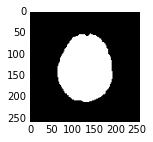

In [24]:
#
# We are going to mask out the background in resultant distance images, so here we find
# the total mask of both input test scans.
# Some operations are performed here because our input images are not completely aligned.
# These operations are not needed when both input scans are from the same subject, and
# we have only one mask image.
#
#
# Set direction cosign of all images to identity and their origins to zero
def ForceDCtoID(inputVolume):
    import os
    import SimpleITK as sitk
    inputVolume.SetDirection((1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0))
    return inputVolume

def ForceOriginToZero(inputVolume):
    import os
    import SimpleITK as sitk
    inputVolume.SetOrigin((0.0, 0.0, 0.0))
    return inputVolume

mask1 = sitk.ReadImage(mask1_fn)
mask1 = ForceDCtoID(mask1)
mask1 = ForceOriginToZero(mask1)

mask2 = sitk.ReadImage(mask2_fn)
mask2 = ForceDCtoID(mask2)
mask2 = ForceOriginToZero(mask2)

mask = sitk.Or(mask1, mask2) # bitwise "OR" of both masks

k = mask.GetSize()[2]/2 # mid-axial slice
mask = mask[:,:,k]

myshow(mask)
print(mask.GetSize())

<type 'numpy.ndarray'>
(128, 128, 70)
<type 'numpy.ndarray'>
(128, 128, 70)
(128, 128, 70)
(70, 128, 128)


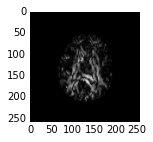

In [28]:
#############
# a more efficient way to compute RIS distance images rather than using for loop
############

print(type(tenfit1.fa))
print(tenfit1.fa.shape)
print(type(tenfit2.fa))
print(tenfit2.fa.shape)

fa_distance_arr = abs(tenfit1.fa-tenfit2.fa)
print(fa_distance_arr.shape)

fa_distance_arr = np.transpose(fa_distance_arr,(2, 1, 0))
print(fa_distance_arr.shape)

fa_distance_image = sitk.GetImageFromArray(fa_distance_arr[35,:,:])
fa_distance_image.CopyInformation(mask)
myshow(fa_distance_image)

In [12]:
##
# create a  2D scalar distance image
##

size_x = data1.shape[0] # x_size
size_y = data1.shape[1] # y_size

fa_distance_image = sitk.Image([size_x,size_y], sitk.sitkFloat32)
fa_distance_image.CopyInformation(mask)

md_distance_image = sitk.Image([size_x,size_y], sitk.sitkFloat32)
md_distance_image.CopyInformation(mask)

rd_distance_image = sitk.Image([size_x,size_y], sitk.sitkFloat32)
rd_distance_image.CopyInformation(mask)

ad_distance_image = sitk.Image([size_x,size_y], sitk.sitkFloat32)
ad_distance_image.CopyInformation(mask)

projection_distance_image = sitk.Image([size_x,size_y], sitk.sitkFloat32)
projection_distance_image.CopyInformation(mask)

frobenius_distance_image = sitk.Image([size_x,size_y], sitk.sitkFloat32)
frobenius_distance_image.CopyInformation(mask)

logeuclid_distance_image = sitk.Image([size_x,size_y], sitk.sitkFloat32)
logeuclid_distance_image.CopyInformation(mask)

reimann_distance_image = sitk.Image([size_x,size_y], sitk.sitkFloat32)
reimann_distance_image.CopyInformation(mask)

kullback_distance_image = sitk.Image([size_x,size_y], sitk.sitkFloat32)
kullback_distance_image.CopyInformation(mask)

In [13]:
##
# For loop on mid-axial slice to create distance images
##
k = data1.shape[2]/2 # mid-axial slice
for i in xrange(data1.shape[0]):
    for j in xrange(data1.shape[1]):
        fa_distance_image[i,j] = abs(tenfit1[i,j,k].fa - tenfit2[i,j,k].fa)
        md_distance_image[i,j] = abs(tenfit1[i,j,k].md - tenfit2[i,j,k].md)
        rd_distance_image[i,j] = abs(tenfit1[i,j,k].rd - tenfit2[i,j,k].rd)
        ad_distance_image[i,j] = abs(tenfit1[i,j,k].ad - tenfit2[i,j,k].ad)
        projection_distance_image[i,j] = projection_metric(tenfit1[i,j,k], tenfit2[i,j,k])
        frobenius_distance_image[i,j] = distance_euclid(tenfit1[i,j,k], tenfit2[i,j,k])
        logeuclid_distance_image[i,j] = distance_logeuclid(tenfit1[i,j,k], tenfit2[i,j,k])
        reimann_distance_image[i,j] = distance_reimann(tenfit1[i,j,k], tenfit2[i,j,k])
        kullback_distance_image[i,j] = distance_kullback(tenfit1[i,j,k], tenfit2[i,j,k])

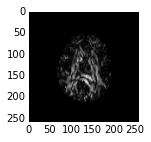

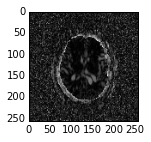

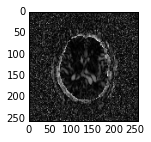

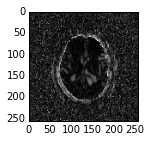

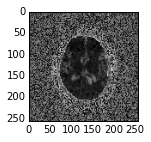

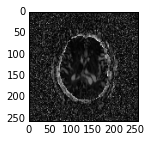

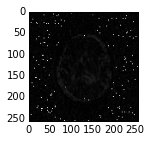

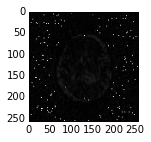

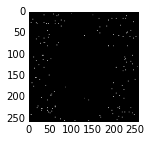

In [14]:
myshow(fa_distance_image)
myshow(md_distance_image)
myshow(rd_distance_image)
myshow(ad_distance_image)
myshow(projection_distance_image)
myshow(frobenius_distance_image)
myshow(logeuclid_distance_image)
myshow(reimann_distance_image)
myshow(kullback_distance_image)

In [15]:
##
# Now mask out the background
##
maskf = sitk.Cast(mask, sitk.sitkFloat32)

fa_distance_image = sitk.Multiply(fa_distance_image,maskf)
md_distance_image = sitk.Multiply(md_distance_image,maskf)
rd_distance_image = sitk.Multiply(rd_distance_image,maskf)
ad_distance_image = sitk.Multiply(ad_distance_image,maskf)
projection_distance_image = sitk.Multiply(projection_distance_image,maskf)
frobenius_distance_image = sitk.Multiply(frobenius_distance_image,maskf)
logeuclid_distance_image = sitk.Multiply(logeuclid_distance_image,maskf)
reimann_distance_image = sitk.Multiply(reimann_distance_image,maskf)
kullback_distance_image = sitk.Multiply(kullback_distance_image,maskf)

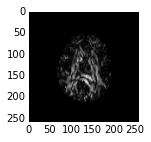

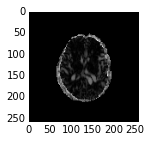

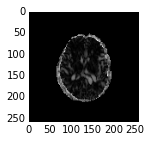

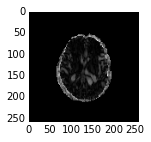

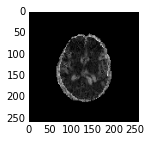

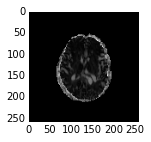

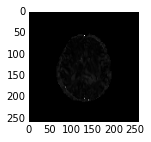

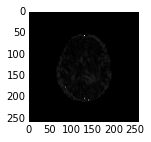

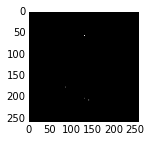

In [16]:
myshow(fa_distance_image)
myshow(md_distance_image)
myshow(rd_distance_image)
myshow(ad_distance_image)
myshow(projection_distance_image)
myshow(frobenius_distance_image)
myshow(logeuclid_distance_image)
myshow(reimann_distance_image)
myshow(kullback_distance_image)

In [17]:
##
# here we clip outliers in above mentioned images by computing 99.7 percentiles
##
######
# TODO: find percentile within mask. It can be performed in ITK.
######
# logeuclid
logeuclid_distance_arr = sitk.GetArrayFromImage(logeuclid_distance_image)
np.clip(logeuclid_distance_arr, 
        logeuclid_distance_arr.min(),
        np.percentile(logeuclid_distance_arr,99.7),
        logeuclid_distance_arr)

# reimann
reimann_distance_arr = sitk.GetArrayFromImage(reimann_distance_image)
np.clip(reimann_distance_arr, 
        reimann_distance_arr.min(),
        np.percentile(reimann_distance_arr,99.7),
        reimann_distance_arr)

# kullback
kullback_distance_arr = sitk.GetArrayFromImage(kullback_distance_image)
#print(kullback_distance_arr.min(), kullback_distance_arr.max())
np.clip(kullback_distance_arr, 
        kullback_distance_arr.min(),
        np.percentile(kullback_distance_arr,99.7),
        kullback_distance_arr)
#print(kullback_distance_arr.min(), kullback_distance_arr.max())

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

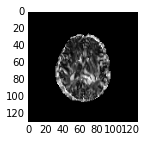

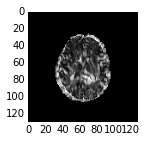

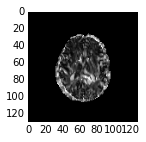

In [18]:
# Now look at clipped images
logeuclid_distance_image = sitk.GetImageFromArray(logeuclid_distance_arr)
myshow(logeuclid_distance_image)

reimann_distance_image = sitk.GetImageFromArray(reimann_distance_arr)
myshow(reimann_distance_image)

kullback_distance_image = sitk.GetImageFromArray(kullback_distance_arr)
myshow(kullback_distance_image)

In [19]:
##
# Now save the 2D distance images as .mat files
##

fa_distance_arr = sitk.GetArrayFromImage(fa_distance_image)
scipy.io.savemat(os.path.join(OUTPUT_DIR,'FA_distance.mat'), mdict={'inputImage': fa_distance_arr})

md_distance_arr = sitk.GetArrayFromImage(md_distance_image)
scipy.io.savemat(os.path.join(OUTPUT_DIR,'MD_distance.mat'), mdict={'inputImage': md_distance_arr})

rd_distance_arr = sitk.GetArrayFromImage(rd_distance_image)
scipy.io.savemat(os.path.join(OUTPUT_DIR,'RD_distance.mat'), mdict={'inputImage': rd_distance_arr})

ad_distance_arr = sitk.GetArrayFromImage(ad_distance_image)
scipy.io.savemat(os.path.join(OUTPUT_DIR,'AD_distance.mat'), mdict={'inputImage': ad_distance_arr})

projection_distance_arr = sitk.GetArrayFromImage(projection_distance_image)
scipy.io.savemat(os.path.join(OUTPUT_DIR,'projection_distance.mat'), mdict={'inputImage': projection_distance_arr})

frobenius_distance_arr = sitk.GetArrayFromImage(frobenius_distance_image)
scipy.io.savemat(os.path.join(OUTPUT_DIR,'frobenius_distance.mat'), mdict={'inputImage': frobenius_distance_arr})

scipy.io.savemat(os.path.join(OUTPUT_DIR,'logeuclid_distance.mat'), mdict={'inputImage': logeuclid_distance_arr})

scipy.io.savemat(os.path.join(OUTPUT_DIR,'reimann_distance.mat'), mdict={'inputImage': reimann_distance_arr})

scipy.io.savemat(os.path.join(OUTPUT_DIR,'kullback_distance.mat'), mdict={'inputImage': kullback_distance_arr})

# Qualitative Evaluations: Display ODFs

Computing tensor ellipsoids in a part of image
Saving illustration as tensor_ellipsoids1.png


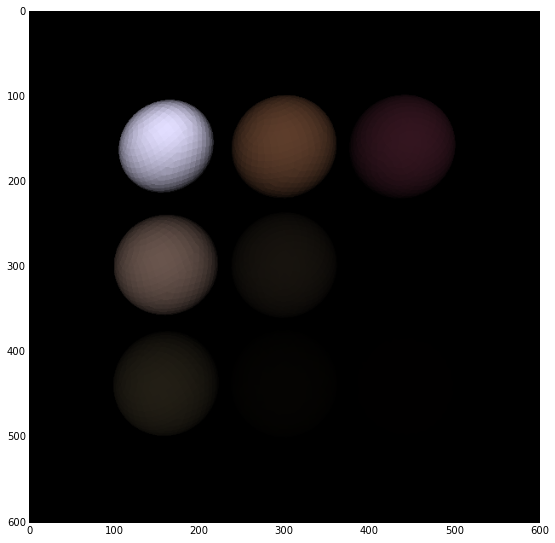

In [20]:
print('Computing tensor ellipsoids in a part of image')

from dipy.data import get_sphere
sphere = get_sphere('symmetric724')

from dipy.viz import fvtk
ren = fvtk.ren()

evals = tenfit1.evals[45:48, 50:53, 35:36]
evecs = tenfit1.evecs[45:48, 50:53, 35:36]

cfa = cfa1[45:48, 50:53, 35:36]
cfa /= cfa.max() 

fvtk.add(ren, fvtk.tensor(evals, evecs, cfa, sphere))
print('Saving illustration as tensor_ellipsoids1.png')
fvtk.record(ren, n_frames=1, out_path=os.path.join(OUTPUT_DIR,'tensor_ellipsoids1.png'), size=(600, 600))

tensor_img1 = sitk.ReadImage(os.path.join(OUTPUT_DIR,'tensor_ellipsoids1.png'))
myshow(tensor_img1)

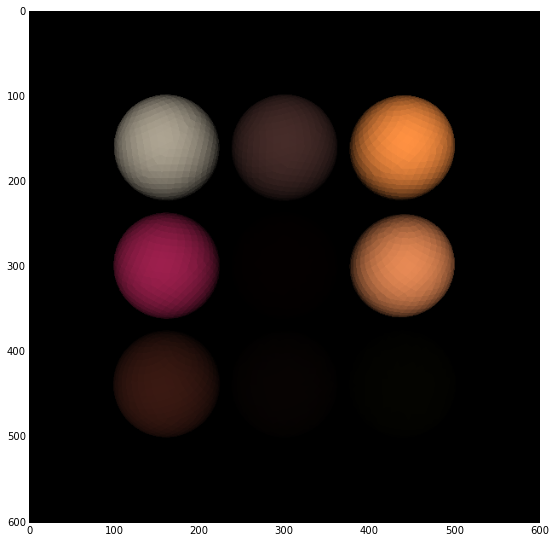

In [21]:
fvtk.clear(ren)

evals = tenfit2.evals[45:48, 50:53, 35:36]
evecs = tenfit2.evecs[45:48, 50:53, 35:36]

cfa = cfa2[45:48, 50:53, 35:36]
cfa /= cfa.max() 

fvtk.add(ren, fvtk.tensor(evals, evecs, cfa, sphere))
fvtk.record(ren, n_frames=1, out_path=os.path.join(OUTPUT_DIR,'tensor_ellipsoids2.png'), size=(600, 600))

tensor_img2 = sitk.ReadImage(os.path.join(OUTPUT_DIR,'tensor_ellipsoids2.png'))
myshow(tensor_img2)

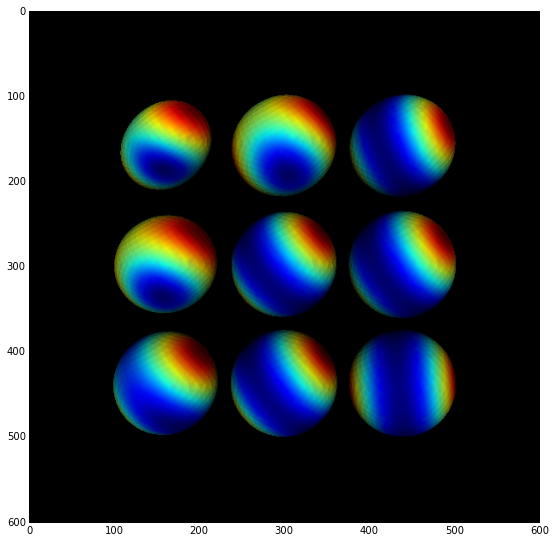

In [22]:
fvtk.clear(ren)

cfa = cfa1[45:48, 50:53, 35:36]
cfa /= cfa.max() 

tensor_odfs = tenfit1[45:48, 50:53, 35:36].odf(sphere)

fvtk.add(ren, fvtk.sphere_funcs(tensor_odfs, sphere, cfa))
fvtk.record(ren, n_frames=1, out_path=os.path.join(OUTPUT_DIR,'tensor_odfs1.png'), size=(600, 600))

odf_img1 = sitk.ReadImage(os.path.join(OUTPUT_DIR,'tensor_odfs1.png'))
myshow(odf_img1)

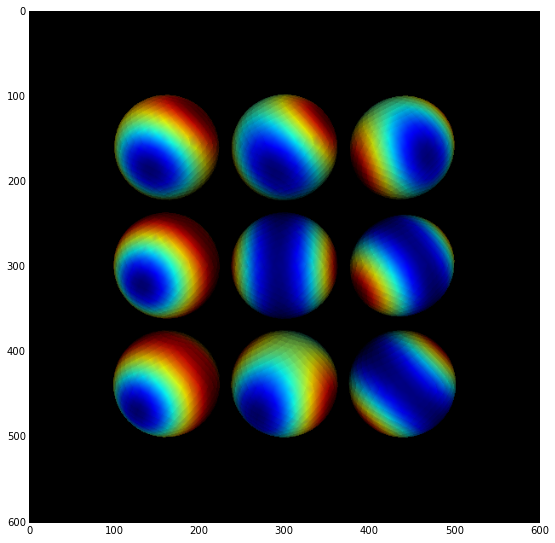

In [23]:
fvtk.clear(ren)

cfa = cfa2[45:48, 50:53, 35:36]
cfa /= cfa.max() 

tensor_odfs = tenfit2[45:48, 50:53, 35:36].odf(sphere)

fvtk.add(ren, fvtk.sphere_funcs(tensor_odfs, sphere, cfa2))
fvtk.record(ren, n_frames=1, out_path=os.path.join(OUTPUT_DIR,'tensor_odfs2.png'), size=(600, 600))

odf_img2 = sitk.ReadImage(os.path.join(OUTPUT_DIR,'tensor_odfs2.png'))
myshow(odf_img2)